# MS025 Preprocess
06/18/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS025'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/MS025/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [6]:
mne_data

<RawEDF | MS025_SWB.edf, 276 x 1454016 (1419.9 s), ~2.99 GB, data loaded>

In [11]:
mne_data.ch_names

['LmOIF1',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'RmOIF1',
 'RmOIF2',
 'RmOIF3',
 'RmOIF4',
 'RmOIF5',
 'RmOIF6',
 'RmOIF7',
 'RmOIF8',
 'RmOIF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LmCmS11',
 'LmCmS12',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'RmCmS9',
 'RmCmS10',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'RAgIT1',
 'RAgIT2',
 'RAgIT3',
 'RAgIT4',
 'RAgIT5',
 'RAgIT6',
 'RAgIT7',
 'RAgIT8',
 'RAgIT9',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',


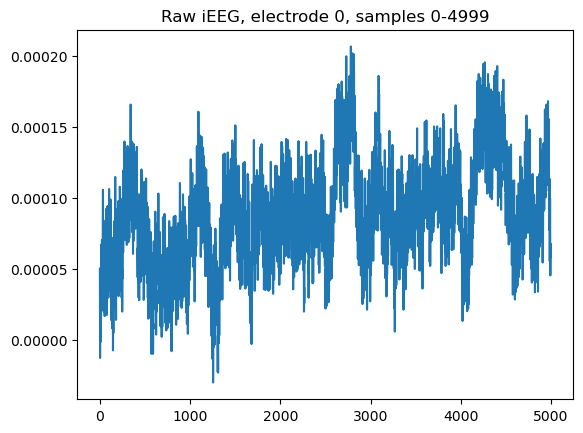

In [12]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

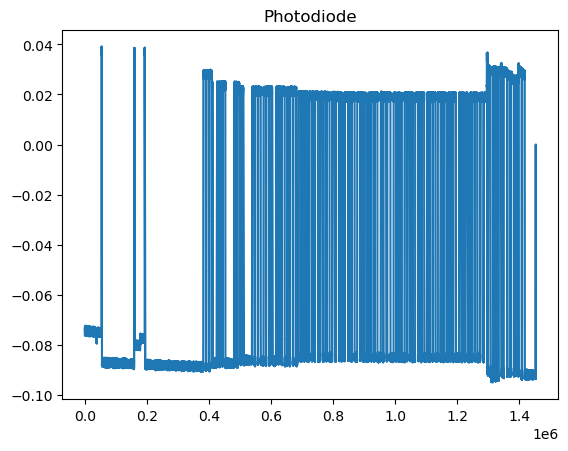

In [13]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [14]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/MS025_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x  \
0     LaCaS1    A32sg_L  -8.551953  47.560752  20.574440  -7.364096   
1    LaCaS10    Unknown -17.348071  64.346899  55.331263 -15.943065   
2    LaCaS11    Unknown -17.747895  65.545910  58.127789 -16.252304   
3    LaCaS12    Unknown -17.747895  65.945580  59.725803 -16.193126   
4     LaCaS2     A32p_L  -9.751424  49.559103  24.968981  -8.600387   
..       ...        ...        ...        ...        ...        ...   
167   RPVNH9    mOccG_R  29.431284 -69.942282  -4.993797  29.084658   
168   uLAglT    rHipp_L -16.148600  10.391424 -14.981390 -16.594453   
169   uLmOlF     A11m_L  -8.951776  61.549208  -4.594294  -7.639574   
170   uRAglT    rHipp_R  15.037636  10.391424 -14.182383  17.162481   
171   uRmOlF     A11m_R   4.242401  55.554155  -6.991316   6.858142   

         mni_y      mni_z       gm  \
0    42.879442   7.816402     Gray   
1    67.827566  42.142829  Unknown   
2    69.749974  44.950649  Unknown   
3    70.554453  46.641912  Unknown   
4    46.074869  12.332196     Gray   
..         ...        ...      ...   
167 -86.459783   9.976051    White   
168  -3.626931 -23.761121     Gray   
169  50.840300 -25.038950     Gray   
170  -3.723941 -23.243948     Gray   
171  44.058306 -26.465903     Gray   

                                                 NMM           Anat  \
0                 Left ACgG anterior cingulate gyrus        Unknown   
1                                            Unknown        Unknown   
2                                            Unknown        Unknown   
3                                            Unknown        Unknown   
4    Left MSFG superior frontal gyrus medial segment        Unknown   
..                                               ...            ...   
167                      Right Cerebral White Matter    Area hOc4lp   
168                                    Left Amygdala  Amygdala (LB)   
169                   Left MOrG medial orbital gyrus       Area Fo1   
170                                   Right Amygdala  Amygdala (LB)   
171                           Right GRe gyrus rectus       Area Fo1   

                    AnatMacro    BN246  \
0                       L ACC     L CG   
1                     Unknown  Unknown   
2                     Unknown  Unknown   
3                     Unknown  Unknown   
4                       L ACC     L CG   
..                        ...      ...   
167  R Middle Occipital Gyrus   R LOcC   
168   L ParaHippocampal Gyrus   L Hipp   
169  L Superior Orbital Gyrus    L OrG   
170   R ParaHippocampal Gyrus   R Hipp   
171            R Rectal Gyrus    R OrG   

                                       YBA_1      manual examination notes  
0                     Left cingulate gyrus F                     NaN   NaN  
1                                    Unknown                     OOB   NaN  
2                                    Unknown                     OOB   NaN  
3                                    Unknown                     OOB   NaN  
4                      Left frontal pole 4 A                     NaN   NaN  
..                                       ...                     ...   ...  
167  Right superior middle occipital gyrus D                     NaN   NaN  
168             Left parahippocampal gyrus A  Left amygdala inferior   NaN  
169                 Left frontal orbital 2 B                     NaN   NaN  
170                  Right amygdala inferior                     NaN   NaN  
171                Right frontal orbital 3 A                     NaN   NaN  

[172 rows x 16 columns]

In [15]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMiP1',
 'LCMiP10',
 'LCMiP11',
 'LCMiP12',
 'LCMiP13',
 'LCMiP14',
 'LCMiP2',
 'LCMiP3',
 'LCMiP4',
 'LCMiP5',
 'LCMiP6',
 'LCMiP7',
 'LCMiP8',
 'LCMiP9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS11',
 'LmCmS12',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmTpT1',
 'LmTpT10',
 'LmTpT2',
 'LmTpT3',
 'LmTpT4',
 'LmTpT5',
 'LmTpT6',
 'LmTpT7',
 'LmTpT8',
 'LmTpT9',
 'LPVNH1',
 'LPVNH10',
 'LPVNH11',
 'LPVNH12',
 'LPVNH13',
 'LPVNH14',
 'LPVNH2',
 'LPVNH3',
 'LPVNH4',
 'LPVNH5',
 'LPVNH6',
 

In [16]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [17]:
unmatched_names

['urmolf', 'ulaglt', 'uraglt', 'ulmolf']

In [18]:
unmatched_seeg  #make sure there are no unmatched names

[]

In [19]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [20]:
new_name_dict

{'LmOIF1': 'lmolf1',
 'LmOIF2': 'lmolf2',
 'LmOIF3': 'lmolf3',
 'LmOIF4': 'lmolf4',
 'LmOIF5': 'lmolf5',
 'LmOIF6': 'lmolf6',
 'LmOIF7': 'lmolf7',
 'LmOIF8': 'lmolf8',
 'LmOIF9': 'lmolf9',
 'RmOIF1': 'rmolf1',
 'RmOIF2': 'rmolf2',
 'RmOIF3': 'rmolf3',
 'RmOIF4': 'rmolf4',
 'RmOIF5': 'rmolf5',
 'RmOIF6': 'rmolf6',
 'RmOIF7': 'rmolf7',
 'RmOIF8': 'rmolf8',
 'RmOIF9': 'rmolf9',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'LaCaS11': 'lacas11',
 'LaCaS12': 'lacas12',
 'RaCaS1': 'racas1',
 'RaCaS2': 'racas2',
 'RaCaS3': 'racas3',
 'RaCaS4': 'racas4',
 'RaCaS5': 'racas5',
 'RaCaS6': 'racas6',
 'RaCaS7': 'racas7',
 'RaCaS8': 'racas8',
 'RaCaS9': 'racas9',
 'RaCaS10': 'racas10',
 'RaCaS11': 'racas11',
 'RaCaS12': 'racas12',
 'LmCmS1': 'lmcms1',
 'LmCmS2': 'lmcms2',
 'LmCmS3': 'lmcms3',
 'LmCmS4': 'lmcms4',
 'LmCmS5': 'lmcms5',
 

In [21]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS025_SWB.edf, 276 x 1454016 (1419.9 s), ~2.99 GB, data loaded>

In [22]:
unmatched_seeg

[]

In [23]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c190', 'c191', 'c192', 'chest1', 'chest2', 'abs1', 'abs2', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [24]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 92 left & 76 right sEEG electrodes
We have a total of 168 sEEG electrodes


In [25]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['c226',
 'c197',
 'dc14',
 'c222',
 'c240',
 'o1',
 'dc4',
 'dc3',
 'dc12',
 'c220',
 't4',
 'pz',
 'c235',
 'dc7',
 'c238',
 'c247',
 'c206',
 'dc2',
 'abs2',
 'c228',
 'cz',
 'c225',
 'c224',
 'c234',
 'dc11',
 'c253',
 'c221',
 'abs1',
 'c241',
 'f4',
 'f8',
 'c203',
 'c211',
 'pleth',
 'c233',
 'dc10',
 'c207',
 'c229',
 'c191',
 'c243',
 't5',
 'c254',
 'c199',
 'f7',
 'c239',
 'p4',
 'c210',
 'chest1',
 'c248',
 'c214',
 'c200',
 'c212',
 'c232',
 'c251',
 'ekg1',
 'c230',
 'trig',
 'ekg2',
 'c4',
 'c192',
 'dc15',
 'c213',
 'c202',
 'c215',
 'c237',
 'c3',
 'c201',
 'c252',
 't6',
 'dc16',
 'c245',
 'dc8',
 'fp1',
 'osat',
 'c256',
 'fp2',
 'c198',
 'c204',
 'c236',
 'c231',
 'c223',
 'c209',
 'c244',
 'c205',
 'c246',
 'pr',
 't3',
 'c255',
 'o2',
 'c227',
 'c216',
 'c217',
 'dc9',
 'c219',
 'fz',
 'p3',
 'c190',
 'chest2',
 'dc13',
 'c208',
 'dc5',
 'c249',
 'c218',
 'dc6',
 'c242',
 'c250',
 'f3']

In [26]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS025_SWB.edf, 169 x 1454016 (1419.9 s), ~1.83 GB, data loaded>

In [27]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} #stim stands for stimulus
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS025_SWB.edf, 169 x 1454016 (1419.9 s), ~1.83 GB, data loaded>

In [28]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS025_SWB.edf, 169 x 1454016 (1419.9 s), ~1.83 GB, data loaded>

### Notch filter line noise

In [29]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    5.7s finished


<RawEDF | MS025_SWB.edf, 169 x 1454016 (1419.9 s), ~1.83 GB, data loaded>

### Resampling Data

In [30]:
#resampling if patient is not sampled at 512
resample_sr = 512
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:    8.8s finished


<RawEDF | MS025_SWB.edf, 169 x 727008 (1419.9 s), ~937.6 MB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [32]:
mne_data.save(f'{neural_dir}/MS025/photodiode.fif', picks='dc1', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [33]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #worked perfectly for this pt besides photodiode
mne_data.info['bads'] = bads

In [34]:
bads #bads picked up research? - manually remove
#bads = bads[:-1]
#bads

['lacas8',
 'lacas9',
 'laglt6',
 'laglt7',
 'lcmip2',
 'lcmip6',
 'lhplt1',
 'lhplt12',
 'lhplt2',
 'lhplt6',
 'lhplt7',
 'lhplt8',
 'lmcms9',
 'lpvnh1',
 'rpvnh6']

In [35]:
mne_data.info['bads'] = bads

In [36]:
mne_data.info

<Info | 10 non-empty values
 bads: 15 items (lacas8, lacas9, laglt6, laglt7, lcmip2, lcmip6, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 168 sEEG
 custom_ref_applied: False
 dig: 168 items (168 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 10:50:08 UTC
 nchan: 168
 projs: []
 sfreq: 512.0 Hz
>

In [37]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [38]:
probe_names

array(['lacas', 'laglt', 'lcmip', 'lhplt', 'lmcms', 'lmolf', 'lmtpt',
       'lpvnh', 'racas', 'raglt', 'rcmip', 'rhplt', 'rmcms', 'rmolf',
       'rpvnh', 'ulaglt', 'ulmolf', 'uraglt', 'urmolf'], dtype='<U6')

In [39]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [40]:
probe_ch_counts

{'lacas': 12,
 'laglt': 9,
 'lcmip': 14,
 'lhplt': 12,
 'lmcms': 12,
 'lmolf': 9,
 'lmtpt': 10,
 'lpvnh': 14,
 'racas': 12,
 'raglt': 9,
 'rcmip': 14,
 'rhplt': 10,
 'rmcms': 10,
 'rmolf': 9,
 'rpvnh': 12,
 'ulaglt': 1,
 'ulmolf': 1,
 'uraglt': 1,
 'urmolf': 1}

<IPython.core.display.Javascript object>


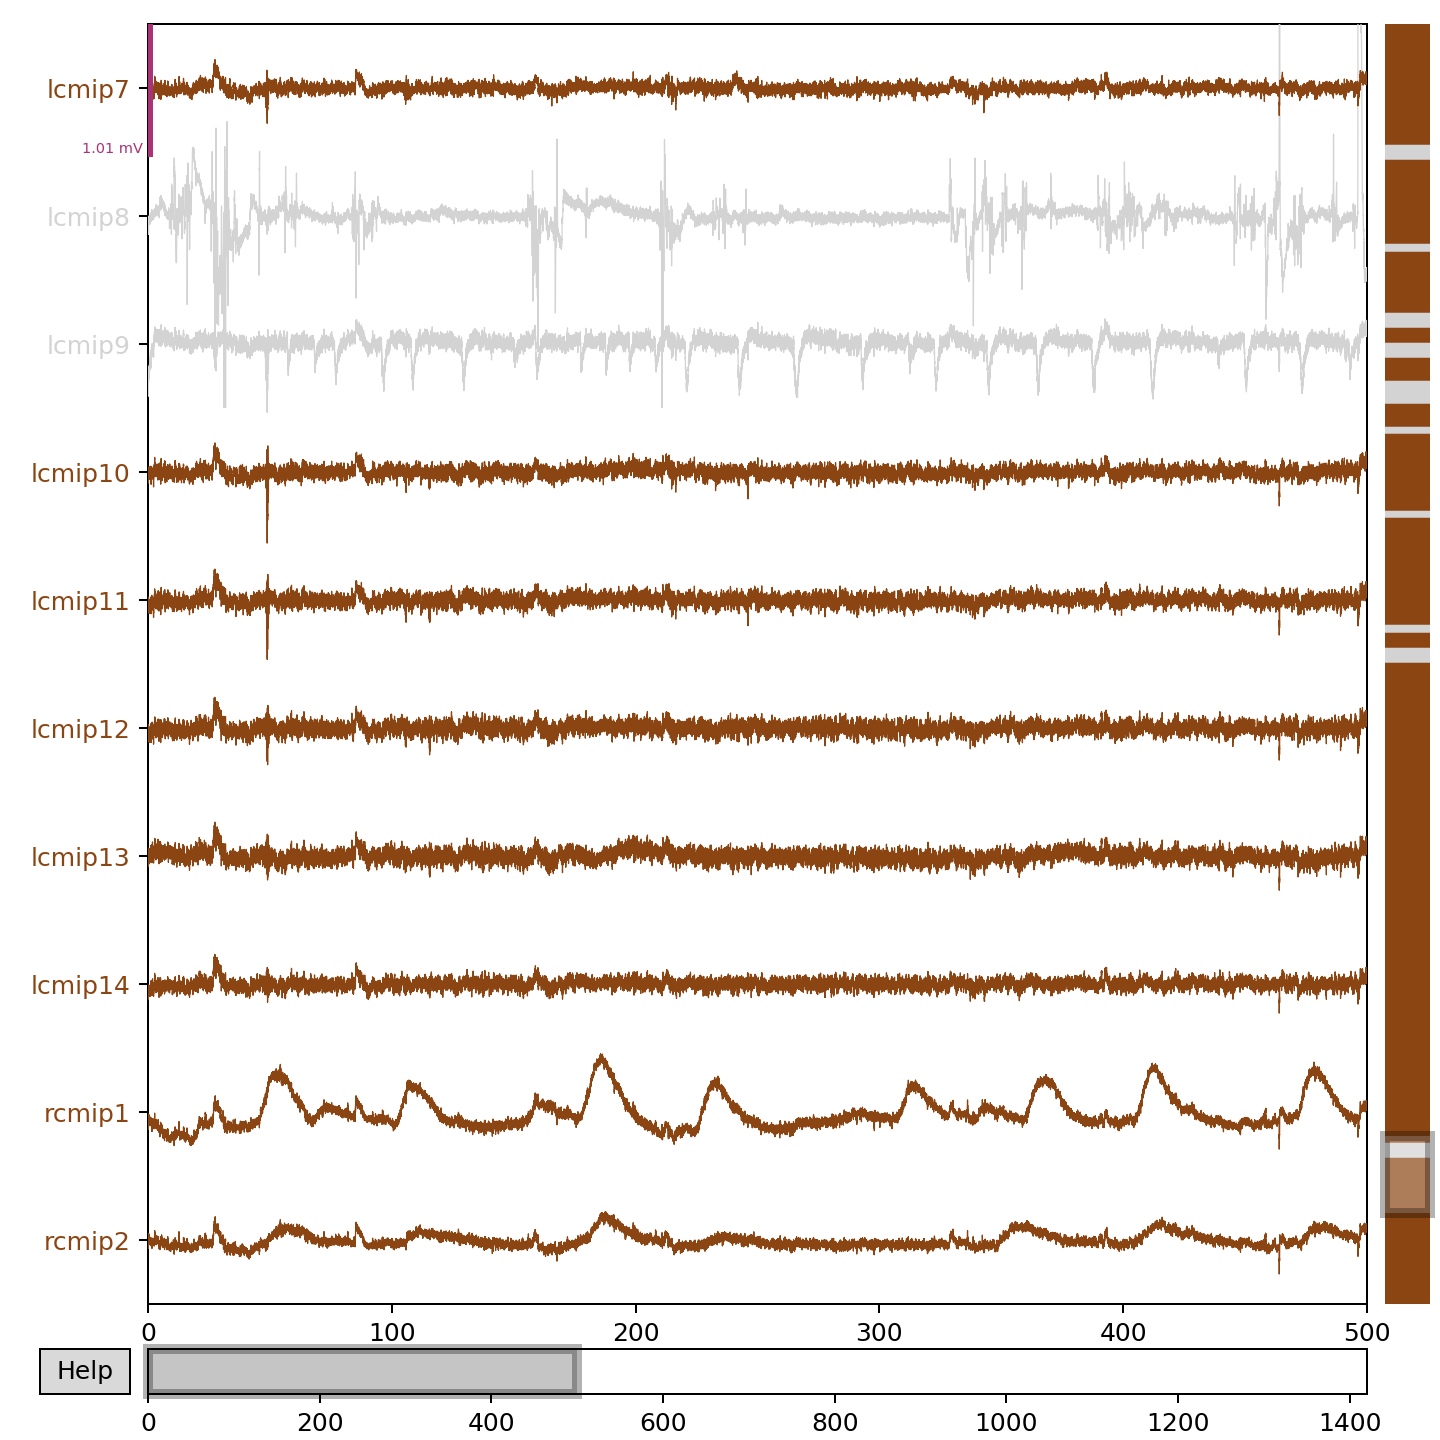

<IPython.core.display.Javascript object>


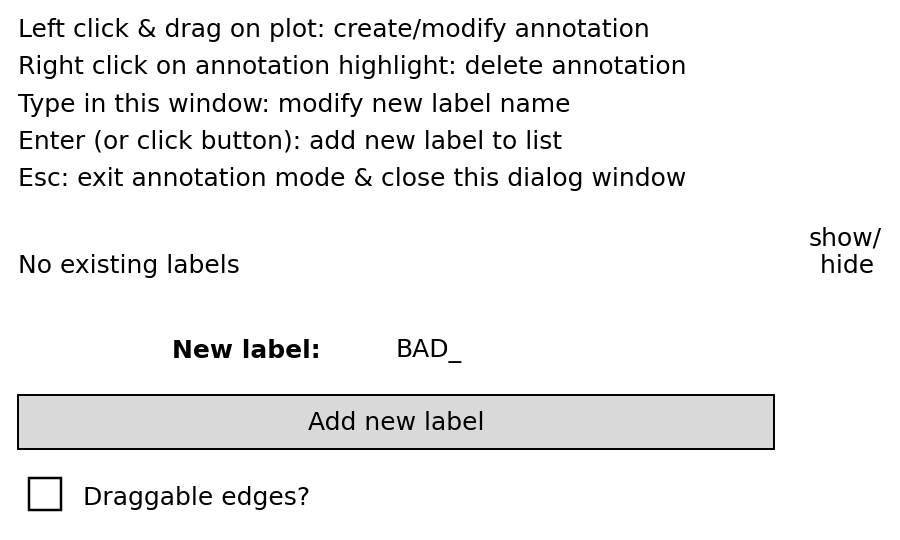

In [41]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [42]:
mne_data.info['bads']

['lacas8',
 'lacas9',
 'laglt6',
 'laglt7',
 'lcmip2',
 'lcmip6',
 'lhplt1',
 'lhplt12',
 'lhplt2',
 'lhplt6',
 'lhplt7',
 'lhplt8',
 'lmcms9',
 'lpvnh1',
 'rpvnh6']

<IPython.core.display.Javascript object>


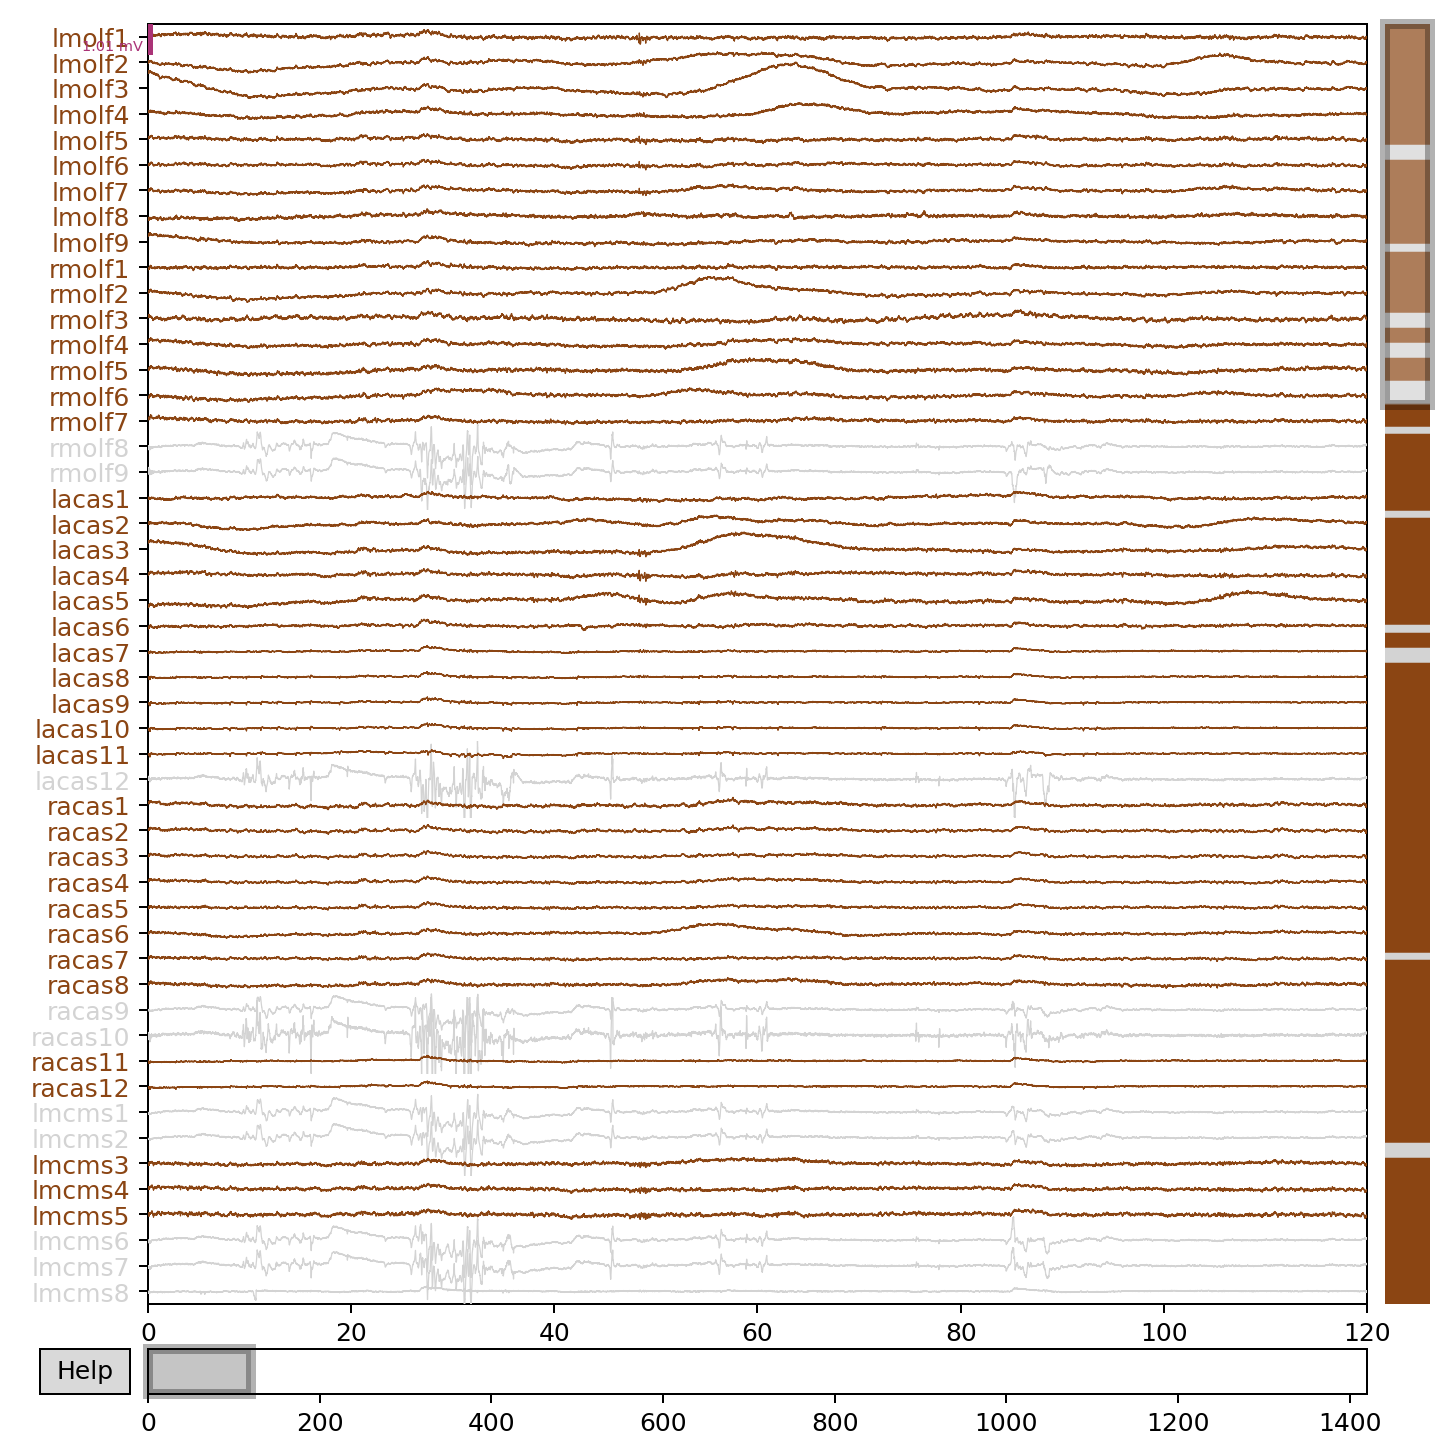

<IPython.core.display.Javascript object>


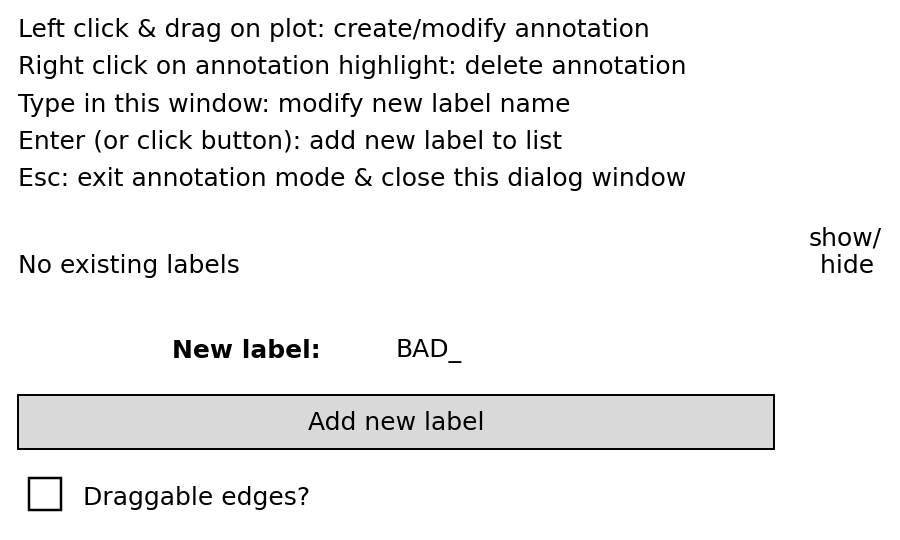

In [45]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [46]:
mne_data.info['bads'] 

['lhplt1',
 'lhplt2',
 'rmolf8',
 'rmolf9',
 'lacas12',
 'racas10',
 'racas9',
 'lmcms1',
 'lmcms2',
 'lmcms6',
 'lmcms7',
 'lmcms12',
 'lmcms8',
 'raglt7',
 'laglt1',
 'lcmip8',
 'lcmip9',
 'lpvnh9']

In [49]:
#set bad channel info 
ms022_bad_ch = ['lhplt1','lhplt2','rmolf8','rmolf9','lacas12','racas10','racas9','lmcms1','lmcms2','lmcms6','lmcms7','lmcms12','lmcms8','raglt7','laglt1','lcmip8','lcmip9','lpvnh9']


In [50]:
len(ms022_bad_ch)

18

In [51]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = ms022_bad_ch 

In [52]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 18 items (lhplt1, lhplt2, rmolf8, rmolf9, lacas12, racas10, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 168 sEEG
 custom_ref_applied: False
 dig: 168 items (168 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 10:50:08 UTC
 nchan: 168
 projs: []
 sfreq: 512.0 Hz
>

In [47]:
mne_data.info['bads'] #more sanity checking

['lacas2',
 'lacas4',
 'lhplt1',
 'lhplt2',
 'lhplt3',
 'laglt3',
 'lmcms1',
 'lmcms2',
 'lmcms4',
 'lmcms5',
 'lmolf1',
 'lmolf2',
 'lmolf3']

### Rereference data to wm electrodes

In [53]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [54]:
oob_channels

['lacas10',
 'lacas11',
 'lacas12',
 'lacas7',
 'lacas8',
 'lacas9',
 'lhplt12',
 'lmcms10',
 'lmcms11',
 'lmcms12',
 'lpvnh14',
 'racas11',
 'racas12',
 'rmcms10',
 'rmcms9',
 'rpvnh12']

In [55]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
ms022_bad_ch = ms022_bad_ch + oob_channels
ms022_bad_ch = list(np.unique(ms022_bad_ch))
mne_data.info['bads'] = ms022_bad_ch

In [56]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas10',
 'lacas11',
 'lacas12',
 'lacas7',
 'lacas8',
 'lacas9',
 'laglt1',
 'lcmip8',
 'lcmip9',
 'lhplt1',
 'lhplt12',
 'lhplt2',
 'lmcms1',
 'lmcms10',
 'lmcms11',
 'lmcms12',
 'lmcms2',
 'lmcms6',
 'lmcms7',
 'lmcms8',
 'lpvnh14',
 'lpvnh9',
 'racas10',
 'racas11',
 'racas12',
 'racas9',
 'raglt7',
 'rmcms10',
 'rmcms9',
 'rmolf8',
 'rmolf9',
 'rpvnh12']

In [57]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [58]:
mne_data_reref

<RawEDF | MS025_SWB.edf, 132 x 727008 (1419.9 s), ~732.3 MB, data loaded>

### Save cleaned continuous data

In [59]:
mne_data.save(f'{neural_dir}/MS025/lfp_data.fif',overwrite=True)

In [60]:
mne_data_reref.save(f'{neural_dir}/MS025/wm_ref_ieeg.fif',overwrite=True)